# Case 1 - Student notebook

Welcome to the helper notebook for case 1. This notebook contains prepared code that you can use to tackle case 1. Specifically, you can find here:

- Code to load the case data.
- Simulation tools to test warehouse purchasing policies.

This notebook is designed to be used in Google Colab. You can also export it and run it in any other Jupyter Notebook environment, but a thing or two will probably break and you will need to fix them yourself. Your choice.

## Imports and Data loading

In [1]:
# Import all the necessary packages
import io
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
from datetime import datetime, timedelta

In [2]:
# Upload files from your computer here
# Run the cell and click the "Browse" button to upload the provided CSV 
# files
uploaded = files.upload()

Saving sourcing_events.csv to sourcing_events.csv
Saving stock_state.csv to stock_state.csv
Saving demand_events.csv to demand_events.csv


In [3]:
# Read the files as pandas dataframes and print them so you can check that the
# process went fine

demand_events = pd.read_csv(io.BytesIO(uploaded['demand_events.csv']))
sourcing_events = pd.read_csv(io.BytesIO(uploaded['sourcing_events.csv']))
stock_state = pd.read_csv(io.BytesIO(uploaded['stock_state.csv']))

for table in (demand_events, sourcing_events, stock_state):
  print(table.head())

         date  demand_quantity
0  2021-01-01     54609.492813
1  2021-01-02     36208.636486
2  2021-01-03     77784.172768
3  2021-01-04     76481.813604
4  2021-01-05     52305.876589
  request_date delivery_date         amount
0   2021-06-18    2021-06-24  361622.084212
1   2021-04-08    2021-04-17  404943.208184
2   2021-08-02    2021-08-10  372079.374931
3   2021-03-23    2021-03-28  324410.868370
4   2021-07-14    2021-07-19  467167.833054
         date  amount_in_stock
0  2021-01-01    647479.251651
1  2021-01-02    611270.615165
2  2021-01-03    533486.442397
3  2021-01-04    457004.628793
4  2021-01-05    404698.752204


## Level 1

From the case description:

    - Elisa wants you to measure the performance of the last year, providing
      quantitative metrics. She knows it was a bad year, but hasn't looked at
      the real data to summarize how bad it was. Remember that there is a
      trade-off: too much stock, is not desired, but running out of stock and making
      clients wait is also negative.
    - Going one step further, Elisa wants to know: what was done wrong?

Use this section to visualize/analyse data from last year to answer Elisa's request.

In [4]:
# Your code goes in cells in this section

## Level 2

From the case description:

    - Elisa wants you to propose an ordering policy. This means, that you need
      to define a rule that, once each day, should answer the questions: should
      be place an order to request material today? If yes, how much should we
      order?
    - Use simulation to present metrics on what is the expected performance
      with the policy you are proposing. Remember, you need to convince Elisa
      that this is better than what happens today.
    - As a specific constraint, Elisa explains that she wants that the
      probability of a stockout to be at most of 5% on any given day.

Use this Level 2 section to learn how to use the provided code and run your own analysis and simulations to answer Elisa's request.

### Prepared simulation code

To help you out, I have prepared some code that will assist you in running simulations. The cells below contain the code and a small example showing you how to use.

In [5]:
# This is the helper code. Run the cell to load it.

base = datetime(2022,1,1)
dates_in_2022 = [base + timedelta(days=x) for x in range(365)]

class SimulationResult:

  def __init__(self, stock_states, demand_by_day, sourcing_events):
    self.stock_states = stock_states
    self.demand_by_day = demand_by_day
    self.sourcing_events = sourcing_events

  def plot_stock_history(self):
    sns.lineplot(x=dates_in_2022, y=self.stock_states)

  def plot_stock_distribution(self):
    sns.histplot(x=self.stock_states, kde=True)

  def service_level(self):
    return (self.stock_states > 0 ).astype(int).mean()

  def stock_level_summary(self):
    print(
        pd.DataFrame(self.stock_states).describe()
    ) 
    
  def mean_stock_level(self):
    return self.stock_states.mean()

  def median_stock_level(self):
    return np.median(self.stock_states)

  def stdev_stock_level(self):
    return self.stock_states.std()

  def mean_demand(self):
    return self.demand_by_day.mean()
  
  def number_of_purchase_orders_placed(self):
    return len(self.sourcing_events)


class SimulationConfig:

  def __init__(self, starting_stock, demand_generator, lead_time_generator, purchaser):
    self.starting_stock = starting_stock
    self.demand_generator = demand_generator
    self.lead_time_generator = lead_time_generator
    self.purchaser = purchaser

class PurchaseOrder:
  
  def __init__(self, amount, request_date, delivery_date):
    self.amount = amount
    self.request_date = request_date
    self.delivery_date = delivery_date

  def __repr__(self):
    return f"Order of {self.amount:.0f}, requested on {self.request_date}, delivery on {self.delivery_date}."


class Simulation:
  
  def __init__(self, config: SimulationConfig, verbose=False):
    self._config = config
    self.verbose = verbose

  def run(self):

    stock_states = np.array([self._config.starting_stock])
    opened_orders = []
    ongoing_orders = {}
    demand_by_day = np.array(list())
  
    for day in dates_in_2022:
      if self.verbose:
        print(f"Simulating day: {day}")
      current_stock = stock_states[-1]
      if self.verbose:
        print(f"Starting stock: {current_stock:.0f}")
      demand_for_this_day = self._config.demand_generator()
      if self.verbose:
        print(f"Generated demand for today: {demand_for_this_day:.0f}")
      demand_by_day = np.append(demand_by_day, [demand_for_this_day])
      goods_received_this_day = 0
      if day in ongoing_orders:
        order_delivered_today = ongoing_orders.pop(day)
        goods_received_this_day = order_delivered_today.amount
      if self.verbose:
        print(f"Goods received today: {goods_received_this_day:.0f}")
      
      current_stock = current_stock + goods_received_this_day - demand_for_this_day
      stock_states = np.append(stock_states, [current_stock])


      order_to_make = self._config.purchaser(
          day, 
          current_stock, 
          ongoing_orders,
          self._config.lead_time_generator
          )

      if order_to_make:
        if self.verbose:
          print(f"Placing a new order: {order_to_make}")
        opened_orders.append(order_to_make)
        ongoing_orders[order_to_make.delivery_date] = order_to_make
    
    stock_states = np.delete(stock_states, 0) # Remove starting stock
    
    self.results = SimulationResult(
        stock_states=stock_states, 
        demand_by_day=demand_by_day, 
        sourcing_events=opened_orders   
    )

    return self.results



### Guide on the prepared code

#### SimulationConfig and PurchaseOrder

In [6]:
# There are four relevant objects you need to know about: Simulation, 
# SimulationConfig, PurchaseOrder and Simulation Result.

# SimulationConfig specifies the context for a simulation. You need to create one
# to run a simulation.

an_example_config = SimulationConfig(
    # How much stock there is in the warehouse when the simulation begins.
    starting_stock=100, 
    # A function that generates the daily demand. You can define any kind of 
    # function, as long as it returns a number and doesn't require any arguments.
    # The example below generates samples from a normal distribution with a mean
    # of 10 and variance of 1.
    demand_generator=lambda: np.random.normal(10, 1),
    # A function that generates the lead time (in days) for purchase orders. 
    # This way, we simulate how long it will take for goods to reach the 
    # warehouse after placing an order. You can define any kind of function, as 
    # long as it returns an integer number and doesn't require any arguments.
    # The example below generates samples from a normal distribution with a mean
    # of 5 and variance of 1, and rounds the result so that we get full days.
    lead_time_generator=lambda: int(np.random.normal(5, 1)),
    # A function that decides when and how much to buy. See more details below.
    purchaser=lambda: "ignore_me_for_now",
)

# A PurchaseOrder represents an order from Caserta to Diemen requesting goods.
an_example_order = PurchaseOrder(
      amount=100,
      # We request a 100.
      request_date=datetime.today(),
      # We request time today
      delivery_date=datetime.today() + timedelta(days=1)
      # We receive them tomorrow
)

# The purchaser function is the logical definition of the proposal you need to
# make to Elisa, which is a policy on when, and how much to buy. 
# The function receives information from the simulation (which day is it, what 
# is the stocklevel, whether there are other ongoing purchase orders, etc.) and 
# either does nothing or decides that a PurchaseOrder should be created.
# This function gets called one time on each day of the simulation, so each 
# simulated day can have a purchase. 

def a_simple_purchaser(
    day, # The current day
    current_stock, # The level of stock on that day
    ongoing_orders, # A dictionary with the open purchase orders
    lead_time_generator # The same lead time generator you pass to the Simulation Config
    ):
  
  if ongoing_orders or current_stock > 100:
    # If we are already waiting for an order to arrive or we have enough stock
    # we don't request more goods.
    return None

  if current_stock <= 100:
    # If the stock is going low, we request 200 more.
    return PurchaseOrder(
      amount=100,
      request_date=day,
      delivery_date=day + timedelta(days=lead_time_generator()) # We simulate the delay in the delivery
    )

# Now that we have a purchaser function, we can complete the SimulationConfig by
# using it.

an_example_config = SimulationConfig(
    starting_stock=100, 
    demand_generator=lambda: np.random.normal(10, 1),
    lead_time_generator=lambda: int(np.random.normal(10, 1)),
    purchaser=a_simple_purchaser
)



#### Simulation

In [7]:
# The Simulation class is the code that actually runs a simulation. It takes a 
# SimulationConfig as an input, and returns a SimulationResult as an output.

example_simulation = Simulation(
    config=an_example_config,
    verbose=True # This shows daily details. Turn to False if you don't want to see them.
)

# Let's run the simulation and store the results

example_simulation_results = example_simulation.run()

Simulating day: 2022-01-01 00:00:00
Starting stock: 100
Generated demand for today: 11
Goods received today: 0
Placing a new order: Order of 100, requested on 2022-01-01 00:00:00, delivery on 2022-01-09 00:00:00.
Simulating day: 2022-01-02 00:00:00
Starting stock: 89
Generated demand for today: 10
Goods received today: 0
Simulating day: 2022-01-03 00:00:00
Starting stock: 79
Generated demand for today: 9
Goods received today: 0
Simulating day: 2022-01-04 00:00:00
Starting stock: 70
Generated demand for today: 8
Goods received today: 0
Simulating day: 2022-01-05 00:00:00
Starting stock: 61
Generated demand for today: 8
Goods received today: 0
Simulating day: 2022-01-06 00:00:00
Starting stock: 53
Generated demand for today: 10
Goods received today: 0
Simulating day: 2022-01-07 00:00:00
Starting stock: 43
Generated demand for today: 10
Goods received today: 0
Simulating day: 2022-01-08 00:00:00
Starting stock: 34
Generated demand for today: 13
Goods received today: 0
Simulating day: 2022

In [8]:
# That was a simulation of a full year with the passed parameters. If you go 
# carefully through the output, you can see the stock, demand and goods received
# on each date, as well as the placing of orders.

#### Simulation Results

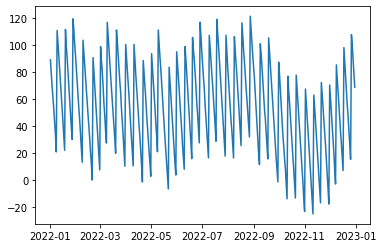

In [9]:
# The SimulationResults objects allows to get some summarized statistics from 
# a simulation. For example, let's plot the stock in the warehouse over that 
# simulation.

example_simulation_results.plot_stock_history()

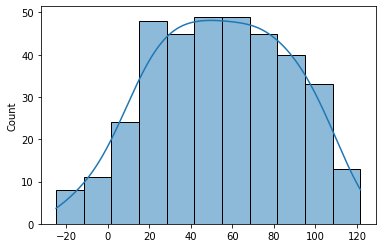

In [10]:
# We can also visualize the distribution of the stock level during the full year

example_simulation_results.plot_stock_distribution()

In [11]:
# And check the details of the distribution

example_simulation_results.stock_level_summary()

                0
count  365.000000
mean    54.411392
std     32.615996
min    -24.762915
25%     29.047827
50%     54.524196
75%     79.744893
max    121.614883


In [12]:
# SimulationResults contains some other helpful functions. See the examples 
# below:

service_level = example_simulation_results.service_level()
mean_stock_level = example_simulation_results.mean_stock_level()
median_stock_level = example_simulation_results.median_stock_level()
stdev_stock_level = example_simulation_results.stdev_stock_level()
number_of_purchase_orders = example_simulation_results.number_of_purchase_orders_placed()


print(f"Demand was properly satisfied on {service_level * 100}% of simulated days.")
print(f"The mean and median stock level were: {mean_stock_level} and {median_stock_level}.")
print(f"There was a total of {number_of_purchase_orders} orders during the simulation.")

Demand was properly satisfied on 95.06849315068493% of simulated days.
The mean and median stock level were: 54.41139166431389 and 54.52419638372521.
There was a total of 37 orders during the simulation.


### Your turn

Now that you are familiar with the provided simulation objects, use them to answer Elisa's requests on level 2.

In [13]:
# Your code goes in cells in this section

## Level 3

From the case description:

    - Right after you finished designing your policy for level 2, Elisa called
      with some news: she has just been informed by the management in Diemen
      that a new Minimum Order Quantity (MOQ) rule will begin soon. This rule
      means that, when the Caserta warehouse places an order to request
      material from, the order should be of at least 500,000 kgs of beans, and
      not less than that.
    - Elisa wants you to take this into account. Does it affect the policy you
      proposed for level 2? If so, you need to come up with a new one that
      adapts to this rule and compare it to the previous one.

In [14]:
# Your code goes in cells in this section

## Level 4

From the case description:

    - Elisa briefly discussed with you in one meeting that there is an option
      to come to an agreement with the team in Diemen to improve the lead time
      stability. The proposal from Diemen is that, if the target lead time was
      set to something higher that the current 7 days target, providing a more
      stable delivery would be feasible.
    - The specific proposal from Diemen is: if the lead time target is changed
      to 15 days, they provide a 100% guarantee that orders will be delivered
      in exactly 15 days.
    - Elisa would love if you could take some additional time to study this
      proposal. What is better for Caserta? The current 7 days target
      lead-time, with unstable deliveries? Or a fixed, 15-day lead time?
    - The MOQ rule of level 3 still applies.

In [15]:
# Your code goes in cells in this section